In [1]:
import os

import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm

from src.data import raw_io as io
from src.data import conditions as cond
from src.features import decomposition as de

In [2]:
np.random.seed(42)

In [3]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'trials_by_celltype')

In [4]:
def load_sessions_by_day(day: cond.Day):
    sessions = {}
    with h5py.File(os.path.join(DATA_PATH, str(day) + '.h5'), 'r') as f:
        for cell_type in cond.CellType:
            sessions[cell_type] = []
            for mouse in f[cell_type.as_path()].keys():
                sessions[cell_type].append(
                    io.SessionTrials.load(f[cell_type.as_path()][mouse])
                )

        f.close()
    
    return sessions

In [5]:
raw_data_by_day = {
    day: load_sessions_by_day(day) for day in cond.DAYS
}

In [6]:
def get_mean_fluorescence_by_cell_type(daily_data: io.SessionTrials):
    mean_fluorescence = {}
    for cell_type in daily_data.keys():

        # Concatenate fluorescence of each mouse
        mean_fluorescence[cell_type] = daily_data[cell_type][0].fluo.trial_mean()
        
        # Transfer meta attributes from SessionTrials to LongFluorescence
        mean_fluorescence[cell_type].set_meta_attr('mouse_id', daily_data[cell_type][0].mouse_id)
        mean_fluorescence[cell_type].set_meta_attr('day', daily_data[cell_type][0].day)
        mean_fluorescence[cell_type].set_meta_attr('cell_type', daily_data[cell_type][0].cell_type)
            
        for i in range(1, len(daily_data[cell_type])):
            trial_mean_fluo = daily_data[cell_type][i].fluo.trial_mean()
            
            # Transfer meta attributes from SessionTrials to LongFluorescence
            trial_mean_fluo.set_meta_attr('mouse_id', daily_data[cell_type][i].mouse_id)
            trial_mean_fluo.set_meta_attr('day', daily_data[cell_type][i].day)
            trial_mean_fluo.set_meta_attr('cell_type', daily_data[cell_type][i].cell_type)
            
            mean_fluorescence[cell_type].append(
                trial_mean_fluo
            )
            del trial_mean_fluo

        print('Got {} {} cells'.format(mean_fluorescence[cell_type].fluo.shape[0], cell_type))
        mean_fluorescence[cell_type].remove_nan()
    
    return mean_fluorescence

In [7]:
mean_fluorescence_by_day = {
    day: get_mean_fluorescence_by_cell_type(raw_data_by_day[day]) 
    for day in raw_data_by_day.keys()
}

Got 1209 pyr cells
Got 189 som cells
Got 252 pv cells
Got 407 vip cells
Got 1730 pyr cells
Got 236 som cells
Got 305 pv cells
Got 513 vip cells
Got 1919 pyr cells
Got 276 som cells
Got 350 pv cells
Got 534 vip cells


/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:759: UserWarning: Removing 2 all-nan rows
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:702: ShapeWarning: `num_frames` in self (428) and other (435) do not match, 7 excess frames will be trimmed from the end of other
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:759: UserWarning: Removing 4 all-nan rows
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:759: UserWarning: Removing 3 all-nan rows
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:759: UserWarning: Removing 5 all-nan rows
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:759: UserWarning: Removing 6 all-nan rows
  warnings.warn(


Got 2098 pyr cells
Got 318 som cells
Got 362 pv cells
Got 565 vip cells


/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:759: UserWarning: Removing 7 all-nan rows
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:702: ShapeWarning: `num_frames` in self (428) and other (438) do not match, 10 excess frames will be trimmed from the end of other
  warnings.warn(


In [8]:
def aggregate_fluorescence(daily_data, num_frames_to_keep=390):
    meta = []
    fluo_matrices = []
    for cell_type in cond.CellType:
        meta.append(daily_data[cell_type]._meta)
        fluo_matrices.append(daily_data[cell_type].fluo)

    min_num_frames = np.min([fl.shape[1] for fl in fluo_matrices])
    assert min_num_frames >= num_frames_to_keep

    meta = pd.concat(meta, ignore_index=True)
    meta.reset_index(inplace=True)
    
    grand_fluo = io.LongFluorescence(
        0, 
        meta['cell_num'], 
        np.concatenate([fl[:, :num_frames_to_keep] for fl in fluo_matrices])
    )
    
    meta['cell_uid'] = meta['mouse_id'] + '_' + meta['cell_type'].astype(str) + '_' + meta['cell_num'].astype(str)
    grand_fluo._meta = meta

    return grand_fluo

In [9]:
grand_fluo_by_day = {day: aggregate_fluorescence(mean_fluorescence_by_day[day]) for day in cond.DAYS}

In [10]:
grand_fluo_by_day[min(cond.DAYS)].get_meta_attr('cell_type')[10]

CellType.pyr

In [11]:
grand_fluo = grand_fluo_by_day[cond.DAYS[0]]

for day in cond.DAYS[1:]:
    grand_fluo.append(grand_fluo_by_day[day])

In [12]:
first_day = []
known_first_days = {}

for uid in tqdm(grand_fluo.get_meta_attr('cell_uid')):
    maybe_first_day = known_first_days.get(uid, False)
    if not maybe_first_day:
        first_day_this_uid = min(
            grand_fluo.get_meta_attr('day')[
                grand_fluo.get_meta_attr('cell_uid') == uid
            ]
        )
        known_first_days[uid] = first_day_this_uid
        first_day.append(first_day_this_uid)
    else:
        first_day.append(maybe_first_day)

grand_fluo.set_meta_attr('first_day', first_day)

del first_day, known_first_days

100%|██████████| 11216/11216 [00:03<00:00, 3377.99it/s]


In [13]:
day7_pca = PCA(random_state=42)
day7_pca.fit(grand_fluo.fluo[grand_fluo.get_meta_attr('day') == max(cond.DAYS), :])
projections = day7_pca.transform(grand_fluo.fluo)

Text(0.5, 0, 'Component no.')

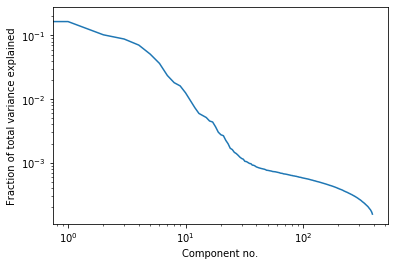

In [14]:
plt.loglog(day7_pca.explained_variance_ratio_)
plt.ylabel('Fraction of total variance explained')
plt.xlabel('Component no.')

In [15]:
day7_pca.components_.shape

(390, 390)

In [16]:
trial_structure = de.TrialBasisFunctions(390)

In [17]:
basis_similarities = {
    trial_component: [
        de.cos_similarity(getattr(trial_structure, trial_component), day7_pca.components_[i, :]) 
        for i in range(390)
    ]
    for trial_component in ['tone', 'delay', 'reward']
}

In [18]:
num_components = 50

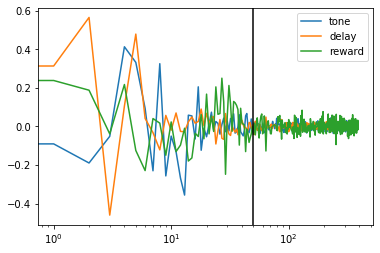

In [19]:
for trial_component in basis_similarities:
    plt.semilogx(basis_similarities[trial_component], label=trial_component)
plt.axvline(num_components, color='k')
plt.legend()

In [20]:
basis_projections = {
    trial_component: de.ols(day7_pca.components_[:num_components, :].T, getattr(trial_structure, trial_component))
    for trial_component in basis_similarities.keys()
}

In [21]:
ideal_projection_similarities = {}

for trial_component in basis_projections.keys():
    ideal_projection_similarities[trial_component] = np.array([
        de.cos_similarity(projections[i, :num_components], basis_projections[trial_component])
        for i in range(projections.shape[0])
    ])

In [22]:
import matplotlib.gridspec as gs

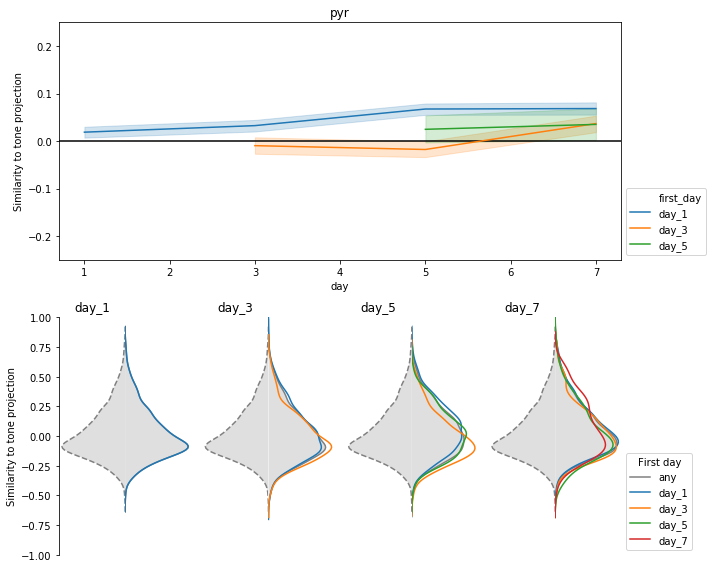

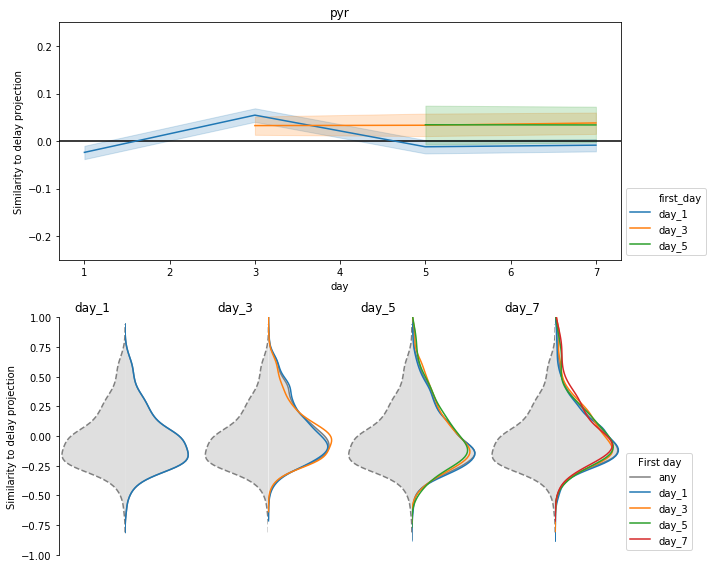

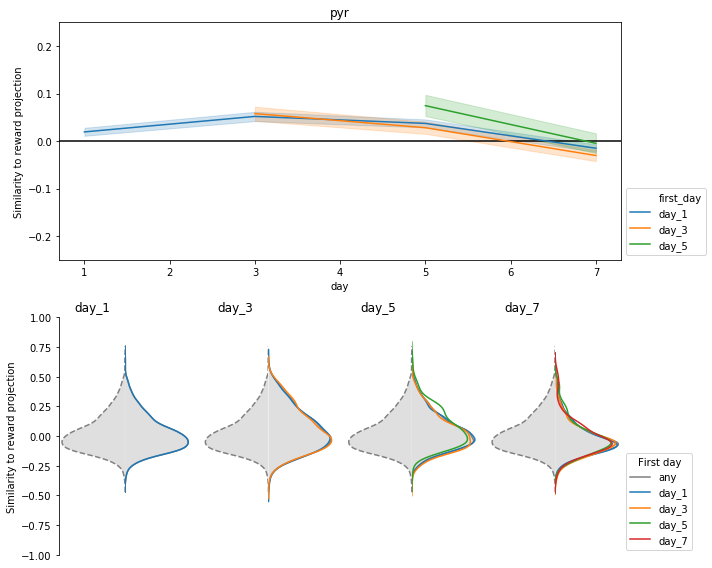

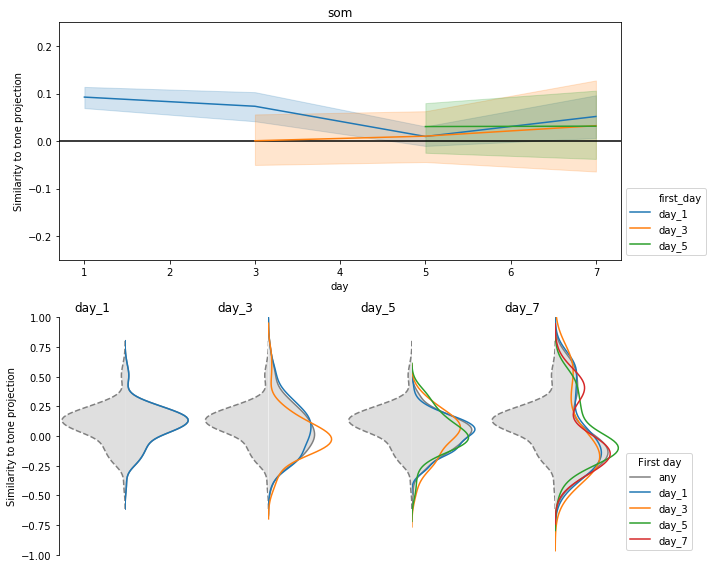

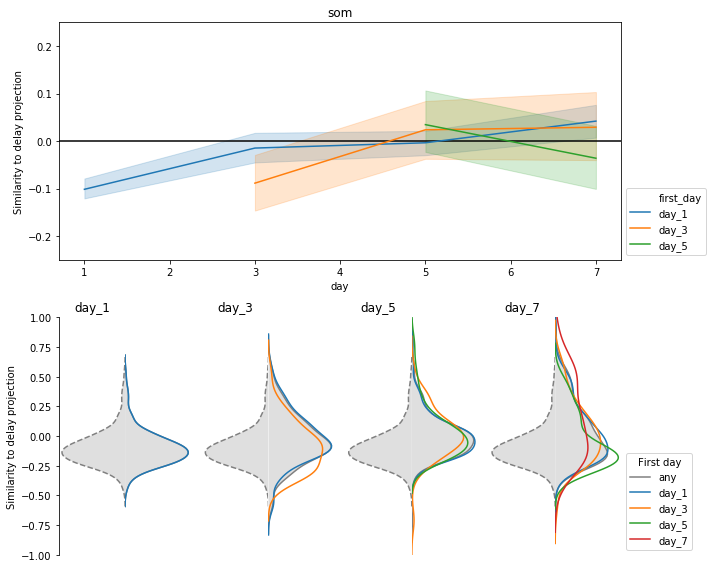

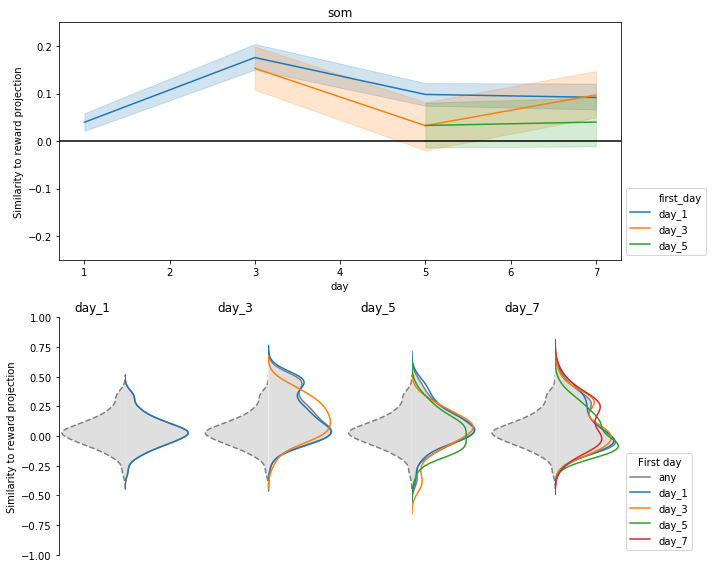

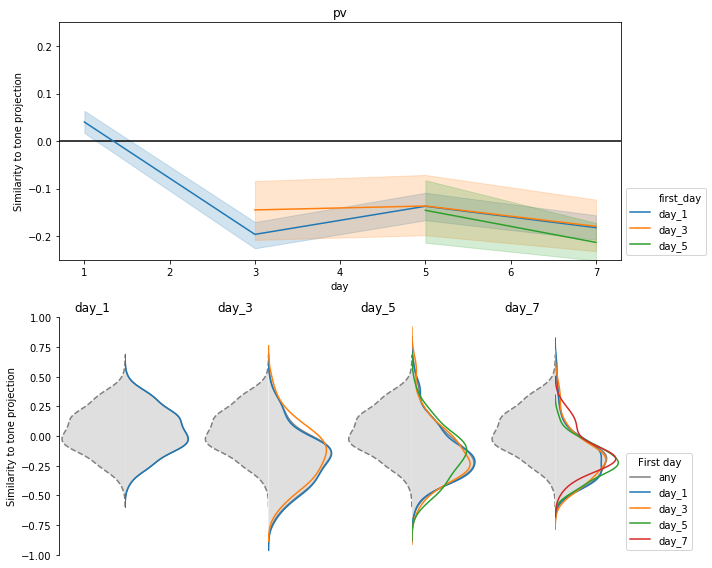

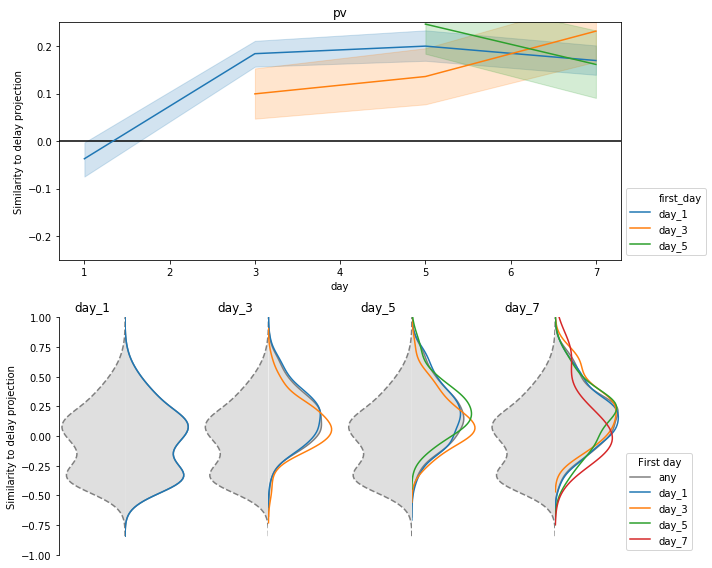

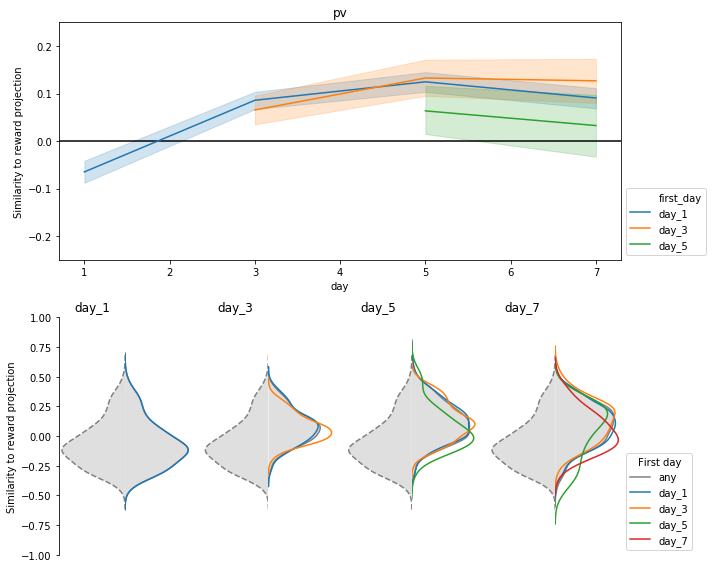

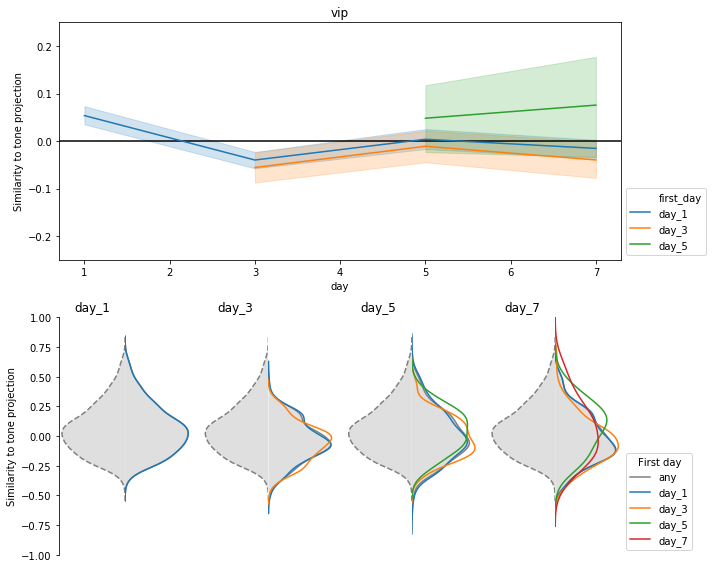

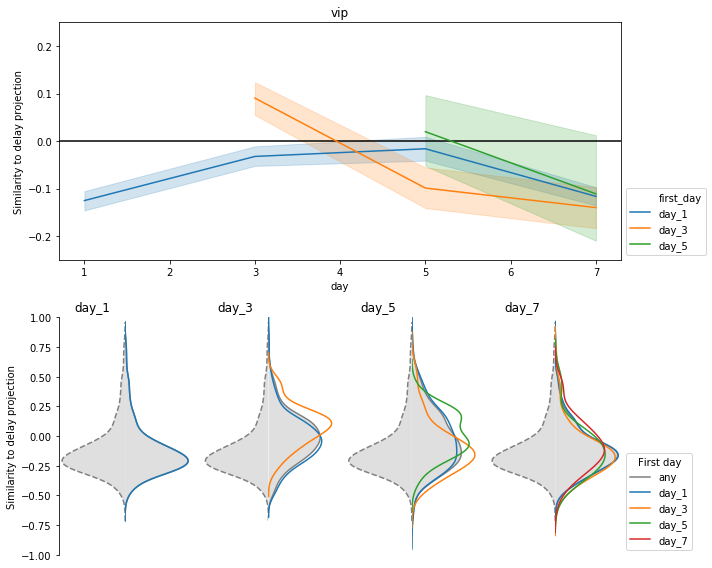

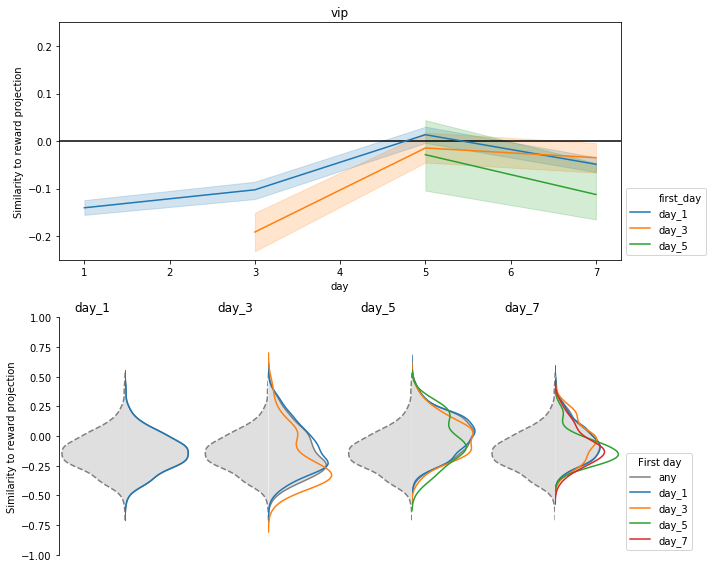

In [23]:
spec = gs.GridSpec(2, 4)

for celltype in cond.CellType:
    for condition in ['tone', 'delay', 'reward']:
        plt.figure(figsize=(10, 8))

        ax_lineplot = plt.subplot(spec[0, :])
        plt.title(str(celltype))
        plt.axhline(0, color='k')
        mask = (
            (grand_fluo.get_meta_attr('cell_type') == celltype) 
            & (grand_fluo.get_meta_attr('first_day').apply(hash) != max(cond.DAYS))
        )
        sns.lineplot(
            x=grand_fluo.get_meta_attr('day')[mask].apply(hash), 
            y=ideal_projection_similarities[condition][mask],
            hue=grand_fluo.get_meta_attr('first_day')[mask],
            ci=95,
            #units=grand_fluo.get_meta_attr('cell_uid')[mask],
            #estimator=None,
            #alpha=0.5
        )
        plt.ylabel('Similarity to {} projection'.format(condition))
        plt.ylim(-0.25, 0.25)
        plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

        for i, day in enumerate(cond.DAYS):
            sub_spec = gs.GridSpecFromSubplotSpec(1, 2, spec[1, i], wspace=0)
            
            plt.subplot(sub_spec[:, 0])
            plt.title(str(day))
            mask = (
                (grand_fluo.get_meta_attr('cell_type') == celltype) 
                & (grand_fluo.get_meta_attr('day') == min(cond.DAYS))
            )
            sns.kdeplot(
                ideal_projection_similarities[condition][mask], 
                vertical=True, shade=True, ls='--', color='gray', label='any'
            )
            plt.gca().invert_xaxis()
            plt.xticks([])
            plt.ylim(-1, 1)
            plt.gca().get_legend().remove()
            
            if i == 0:
                plt.ylabel('Similarity to {} projection'.format(condition))
                sns.despine(ax=plt.gca(), top=True, right=True, bottom=True)
            else:
                plt.yticks([])
                sns.despine(ax=plt.gca(), top=True, left=True, bottom=True, right=True)
            
            plt.subplot(sub_spec[:, 1])

            mask = (
                (grand_fluo.get_meta_attr('cell_type') == celltype) 
                & (grand_fluo.get_meta_attr('day') == day)
            )
            sns.kdeplot(
                ideal_projection_similarities[condition][mask], 
                vertical=True, shade=True, color='gray', label='any'
            )

            for first_day in cond.DAYS:

                mask = (
                    (grand_fluo.get_meta_attr('cell_type') == celltype) 
                    & (grand_fluo.get_meta_attr('day') == day)
                    & (grand_fluo.get_meta_attr('first_day') == first_day)
                )
                sns.kdeplot(ideal_projection_similarities[condition][mask], vertical=True, label=first_day)

            plt.ylim(-1, 1)

            plt.yticks([])

            if i == len(cond.DAYS) - 1:
                plt.legend(title='First day', loc='lower left', bbox_to_anchor=(1, 0))
            else:
                plt.gca().get_legend().remove()
            sns.despine(ax=plt.gca(), top=True, left=True, bottom=True, right=True)

            plt.xticks([])

        plt.tight_layout()